# Quora Question Pairs

## Intro
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

## Goal
The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

# 1. Data Exploration

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
%matplotlib inline
jtplot.style()

In [20]:
# load data
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [21]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [22]:
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [23]:
len(df_train)

404290

In [24]:
len(df_test)

2345796

## Base stats

In [25]:
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('#unique questions: {}'.format(len(set(qids))))


Duplicate pairs: 36.92%
#unique questions: 537933


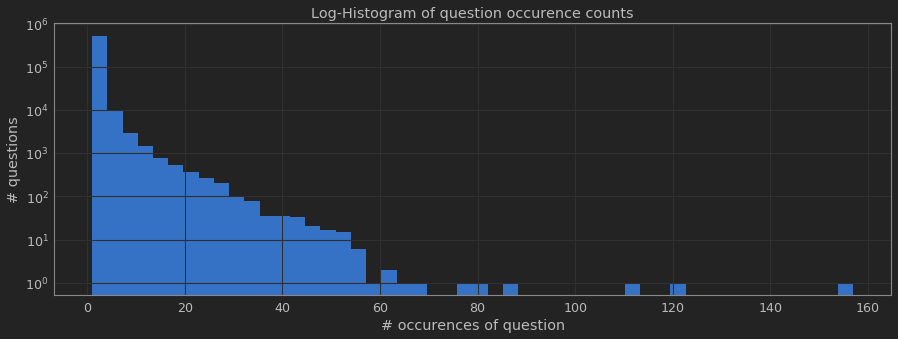

In [27]:
plt.figure(figsize=(15, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question occurence counts')
plt.xlabel('# occurences of question')
plt.ylabel('# questions')

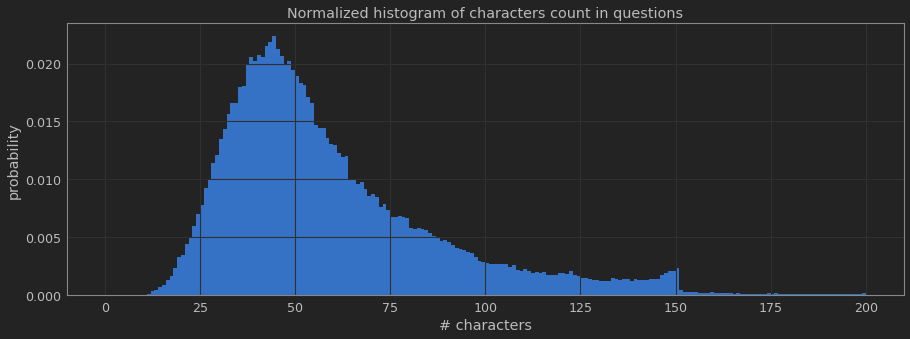

In [29]:
train_qs = pd.Series(
    df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
dist_train = train_qs.apply(len)

plt.figure(figsize=(15,5))
plt.hist(dist_train, bins=200, range=[0, 200], normed=True, label='train')
plt.title('Normalized histogram of character counts in questions')
plt.xlabel('# characters')
plt.ylabel('probability')

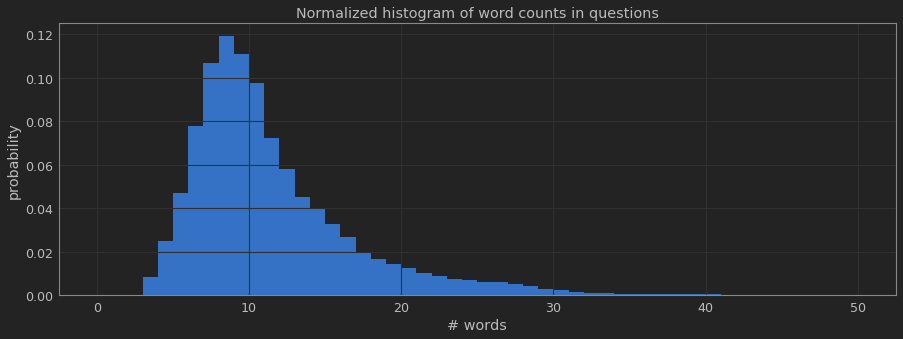

In [30]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15,5))
plt.hist(dist_train, bins=50, range=[0, 50], normed=True)
plt.title('Normalized histogram of word counts in questions')
plt.xlabel('# words')
plt.ylabel('probability')

(-0.5, 1999.5, 999.5, -0.5)

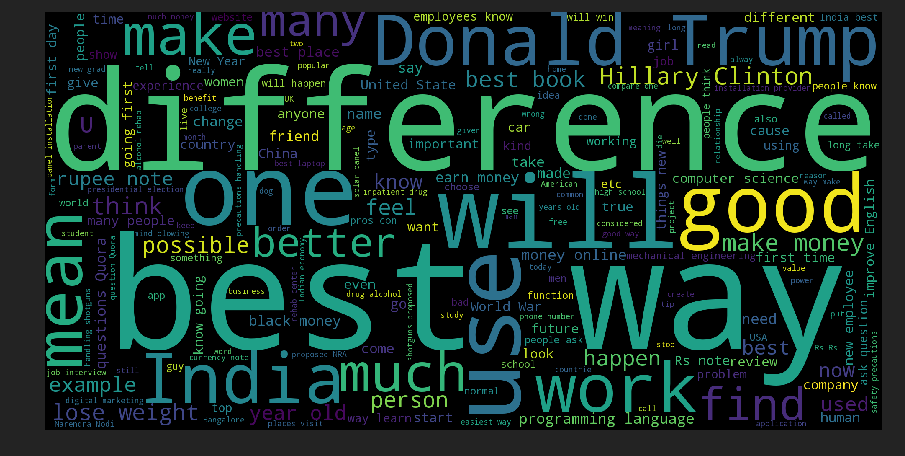

In [33]:
from wordcloud import WordCloud
cloud = WordCloud(width=2000, height=1000).generate(' '.join(train_qs.astype(str)))
plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')